# **Chapter 25. MapReduce**

## **Exampe: Word Count**

In [ ]:
# Non-MapReduce

from typing import List
from collections import Counter

def tokenize(document: str) -> List[str]:
    """Just split on whitespace"""
    return document.split()

def word_count_old(documents: List[str]):
    """Word Count not using MapReduce"""
    return Counter(word
        for document in documents
        for word in tokenize(document))

In [ ]:
from typing import Iterator, Tuple

def wc_mapper(document: str) -> Iterator[Tuple[str, int]]:
    """For each word in the document, emit (word, 1)"""
    for word in tokenize(document):
        yield (word, 1)

from typing import Iterable

def wc_reducer(word: str,
               counts: Iterable[int]) -> Iterator[Tuple[str, int]]:
    """Sum up the counts for a word"""
    yield (word, sum(counts))

from collections import defaultdict

def word_count(documents: List[str]) -> List[Tuple[str, int]]:
    """Count the words in the input documents using MapReduce"""

    collector = defaultdict(list)  # To store grouped values

    for document in documents:
        for word, count in wc_mapper(document):
            collector[word].append(count)

    return [output
            for word, counts in collector.items()
            for output in wc_reducer(word, counts)]

In [ ]:
wc = word_count(["data science", "big data", "science fiction"])
assert len(wc) == 4
assert set(wc) == {("data", 2), ("science", 2), ("big", 1), ("fiction", 1)}

## **MapReduce More Generally**

In [ ]:
from typing import Callable, Iterable, Any, Tuple

# A key-value pair is just a 2-tuple
KV = Tuple[Any, Any]

# A Mapper is a function that returns an Iterable of key-value pairs
Mapper = Callable[..., Iterable[KV]]

# A Reducer is a function that takes a key and an iterable of values
# and returns a key-value pair
Reducer = Callable[[Any, Iterable], KV]

def map_reduce(inputs: Iterable,
               mapper: Mapper,
               reducer: Reducer) -> List[KV]:
    """Run MapReduce on the inputs using mapper and reducer"""
    collector = defaultdict(list)

    for input in inputs:
        for key, value in mapper(input):
            collector[key].append(value)

    return [output
            for key, values in collector.items()
            for output in reducer(key, values)]

def values_reducer(values_fn: Callable) -> Reducer:
    """Return a reducer that just applies values_fn to its values"""
    def reduce(key, values: Iterable) -> KV:
        return (key, values_fn(values))

    return reduce

sum_reducer = values_reducer(sum)
max_reducer = values_reducer(max)
min_reducer = values_reducer(min)
count_distinct_reducer = values_reducer(lambda values: len(set(values)))

assert sum_reducer("key", [1, 2, 3, 3]) == ("key", 9)
assert min_reducer("key", [1, 2, 3, 3]) == ("key", 1)
assert max_reducer("key", [1, 2, 3, 3]) == ("key", 3)
assert count_distinct_reducer("key", [1, 2, 3, 3]) == ("key", 3)

## **Example: Analyzing Status Updates**

* Let's say we need to figure out which day of the week people talk the most about data science. In order to find this, we'll just count how many data science updates there are on each day of the week. This means we'll need to group by the day of week, so that's our key. And if we emit a value of 1 for each update that contains "data science," we can simply get the total number using sum:

In [ ]:
# Analyzing status updates

import datetime

status_updates = [
    {"id": 2,
      "username" : "joelgrus",
      "text" : "Should I write a second edition of my data science book?",
      "created_at" : datetime.datetime(2018, 2, 21, 11, 47, 0),
      "liked_by" : ["data_guy", "data_gal", "mike"] },
      # ...
]

def data_science_day_mapper(status_update: dict) -> Iterable:
    """Yields (day_of_week, 1) if status_update contains "data science" """
    if "data science" in status_update["text"].lower():
        day_of_week = status_update["created_at"].weekday()
        yield (day_of_week, 1)

data_science_days = map_reduce(status_updates,
                                data_science_day_mapper,
                                sum_reducer)

* As a slightly more complicated example, imagine we need to find out for each user the most common word that she puts in her status updates. 

In [ ]:
def words_per_user_mapper(status_update: dict):
    user = status_update["username"]
    for word in tokenize(status_update["text"]):
        yield (user, (word, 1))

def most_popular_word_reducer(user: str,
                              words_and_counts: Iterable[KV]):
    """
    Given a sequence of (word, count) pairs,
    return the word with the highest total count
    """
    word_counts = Counter()
    for word, count in words_and_counts:
        word_counts[word] += count

    word, count = word_counts.most_common(1)[0]

    yield (user, (word, count))

user_words = map_reduce(status_updates,
                        words_per_user_mapper,
                        most_popular_word_reducer)

* Or we could find out the number of distinct status-likers for each user:

In [ ]:
def liker_mapper(status_update: dict):
    user = status_update["username"]
    for liker in status_update["liked_by"]:
        yield (user, liker)

distinct_likers_per_user = map_reduce(status_updates,
                                      liker_mapper,
                                      count_distinct_reducer)

## **Example: Matrix Multiplication**

* To motivate our algorithm, notice that each element A[i][j] is only used to compute the elements of C in row i, and each element B[i][j] is only used to compute the elements of C in column j. Our goal will be for each output of our reducer to be a single entry of C, which means we'll need our mapper to emit keys identifying a single entry of C.

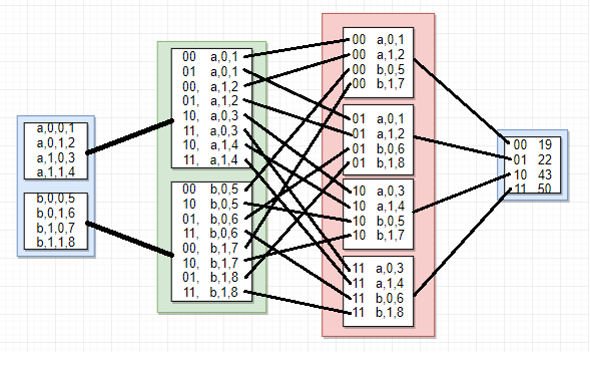

In [ ]:
# Non-MapReduce
# C[i][j] = sum(A[i][x] * B[x][j] for x in range(m))

from typing import NamedTuple

class Entry(NamedTuple):
    name: str
    i: int
    j: int
    value: float

def matrix_multiply_mapper(num_rows_a: int, num_cols_b: int) -> Mapper:
    # C[x][y] = A[x][0] * B[0][y] + ... + A[x][m] * B[m][y]
    #
    # so an element A[i][j] goes into every C[i][y] with coef B[j][y]
    # and an element B[i][j] goes into every C[x][j] with coef A[x][i]
    def mapper(entry: Entry):
        if entry.name == "A":
            for y in range(num_cols_b):
                key = (entry.i, y)              # which element of C
                value = (entry.j, entry.value)  # which entry in the sum
                yield (key, value)
        else:
            for x in range(num_rows_a):
                key = (x, entry.j)              # which element of C
                value = (entry.i, entry.value)  # which entry in the sum
                yield (key, value)

    return mapper

def matrix_multiply_reducer(key: Tuple[int, int],
                            indexed_values: Iterable[Tuple[int, int]]):
    results_by_index = defaultdict(list)

    for index, value in indexed_values:
        results_by_index[index].append(value)

    # Multiply the values for positions with two values
    # (one from A, and one from B) and sum them up.
    sumproduct = sum(values[0] * values[1]
                     for values in results_by_index.values()
                     if len(values) == 2)

    if sumproduct != 0.0:
        yield (key, sumproduct)

A = [[3, 2, 0],
     [0, 0, 0]]

B = [[4, -1, 0],
     [10, 0, 0],
     [0, 0, 0]]

entries = [Entry("A", 0, 0, 3), Entry("A", 0, 1,  2), Entry("B", 0, 0, 4),
            Entry("B", 0, 1, -1), Entry("B", 1, 0, 10)]


mapper = matrix_multiply_mapper(num_rows_a=2, num_cols_b=3)
reducer = matrix_multiply_reducer

# Product should be [[32, -3, 0], [0, 0, 0]].
# So it should have two entries.
assert (set(map_reduce(entries, mapper, reducer)) ==
        {((0, 1), -3), ((0, 0), 32)})